In [1]:
import pandas as pd

In [11]:
df = pd.read_csv("datasets/features/train.csv")
test = pd.read_csv("datasets/features/test.csv")

In [3]:
df.head()

,date,store_nbr,city,state,type,cluster,family,onpromotion,dcoilwtico,day_week,holiday_or_weekday,sales
0,2013-01-01,1,18,12,3,13,0,0,93.14,1,0,0.0
1,2013-01-01,1,18,12,3,13,1,0,93.14,1,0,0.0
2,2013-01-01,1,18,12,3,13,2,0,93.14,1,0,0.0
3,2013-01-01,1,18,12,3,13,3,0,93.14,1,0,0.0
4,2013-01-01,1,18,12,3,13,4,0,93.14,1,0,0.0


In [4]:
df.shape

(2596374, 12)

In [5]:
df.date.min()

'2013-01-01'

In [6]:
df.date.max()

'2016-12-31'

In [7]:
df_sales = df.copy()
#convert date field from string to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'])
#represent month in date field as its first day
# df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
# df_sales['date'] = pd.to_datetime(df_sales['date'])
#groupby date and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()

In [12]:
df_sales_test = test.copy()
#convert date field from string to datetime
df_sales_test['date'] = pd.to_datetime(df_sales_test['date'])
#represent month in date field as its first day
# df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
# df_sales['date'] = pd.to_datetime(df_sales['date'])
#groupby date and sum the sales
df_sales_test = df_sales_test.groupby('date').sales.sum().reset_index()

In [8]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head()

,date,sales,prev_sales,diff
1,2013-01-02,496092.417944,2511.618999,493580.798945
2,2013-01-03,361461.231124,496092.417944,-134631.186820
3,2013-01-04,354459.677093,361461.231124,-7001.554031
4,2013-01-05,477350.121229,354459.677093,122890.444136
5,2013-01-06,519695.401088,477350.121229,42345.279859


In [13]:
#create a new dataframe to model the difference
df_diff_test = df_sales_test.copy()
#add previous sales to the next row
df_diff_test['prev_sales'] = df_diff_test['sales'].shift(1)
#drop the null values and calculate the difference
df_diff_test = df_diff_test.dropna()
df_diff_test['diff'] = (df_diff_test['sales'] - df_diff_test['prev_sales'])
df_diff_test.head()

,date,sales,prev_sales,diff
1,2017-01-02,1.402306e+06,1.208250e+04,1.390224e+06
2,2017-01-03,1.104377e+06,1.402306e+06,-2.979293e+05
3,2017-01-04,9.900935e+05,1.104377e+06,-1.142836e+05
4,2017-01-05,7.776210e+05,9.900935e+05,-2.124725e+05
5,2017-01-06,8.396002e+05,7.776210e+05,6.197928e+04


In [9]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'], axis=1)
#adding lags
for inc in range(1, 13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [14]:
#create dataframe for transformation from time series to supervised
df_supervised_test = df_diff_test.drop(['prev_sales'], axis=1)
#adding lags
for inc in range(1, 13):
    field_name = 'lag_' + str(inc)
    df_supervised_test[field_name] = df_supervised_test['diff'].shift(inc)
#drop null values
df_supervised_test = df_supervised_test.dropna().reset_index(drop=True)

In [10]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)
# 0.02893426930900389

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+ lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7+ lag_8 +lag_9 \
                +lag_10+lag_11+lag_12', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)
# 0.9795722233296558

-0.00031239832485230323
0.6044076913651311


In [15]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
train_set = df_supervised.drop(['sales', 'date'], axis=1)
test_set = df_supervised_test.drop(['sales', 'date'], axis=1)
#split train and test set
# train: 2014-02-01 ~ 2017-06-01, test_set: 2017-07-01 ~ 2017-12-01
# train_set, test_set = df_model[0:-6].values, df_model[-6:].values
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [18]:
df_supervised.head()

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2013-01-14,293348.362078,-171290.185920,61380.335987,113520.526926,30755.682036,-43548.805969,-15816.968963,-17775.023085,-183572.600022,42345.279859,122890.444136,-7001.554031,-134631.186820,493580.798945
1,2013-01-15,299129.549954,5781.187876,-171290.185920,61380.335987,113520.526926,30755.682036,-43548.805969,-15816.968963,-17775.023085,-183572.600022,42345.279859,122890.444136,-7001.554031,-134631.186820
2,2013-01-16,318347.913946,19218.363992,5781.187876,-171290.185920,61380.335987,113520.526926,30755.682036,-43548.805969,-15816.968963,-17775.023085,-183572.600022,42345.279859,122890.444136,-7001.554031
3,2013-01-17,267498.515975,-50849.397970,19218.363992,5781.187876,-171290.185920,61380.335987,113520.526926,30755.682036,-43548.805969,-15816.968963,-17775.023085,-183572.600022,42345.279859,122890.444136
4,2013-01-18,296130.850028,28632.334053,-50849.397970,19218.363992,5781.187876,-171290.185920,61380.335987,113520.526926,30755.682036,-43548.805969,-15816.968963,-17775.023085,-183572.600022,42345.279859


In [19]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, TimeDistributed

# single LSTM model
model = Sequential()
model.add(
    LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True)
)
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
history = model.fit(
    X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False
)
# BiLSTM model
model = Sequential()
model.add(
    Bidirectional(
        LSTM(4, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])
    )
)
model.add(TimeDistributed(Dense(1)))
model.compile(loss="mean_squared_error", optimizer="adam")
history_TD_bilstm = model.fit(X_train, y_train, epochs=100, verbose=1, shuffle=False)

Epoch 1/100
1444/1444 [==============================] - 1s 621us/step - loss: 0.0144
Epoch 2/100
1444/1444 [==============================] - 1s 578us/step - loss: 0.0091
Epoch 3/100
1444/1444 [==============================] - 1s 580us/step - loss: 0.0085
Epoch 4/100
1444/1444 [==============================] - 1s 569us/step - loss: 0.0083
Epoch 5/100
1444/1444 [==============================] - 1s 611us/step - loss: 0.0081
Epoch 6/100
1444/1444 [==============================] - 1s 570us/step - loss: 0.0079
Epoch 7/100
1444/1444 [==============================] - 1s 571us/step - loss: 0.0078
Epoch 8/100
1444/1444 [==============================] - 1s 571us/step - loss: 0.0077
Epoch 9/100
1444/1444 [==============================] - 1s 570us/step - loss: 0.0076
Epoch 10/100
1444/1444 [==============================] - 1s 573us/step - loss: 0.0075
Epoch 11/100
1444/1444 [==============================] - 1s 570us/step - loss: 0.0074
Epoch 12/100
1444/1444 [============================

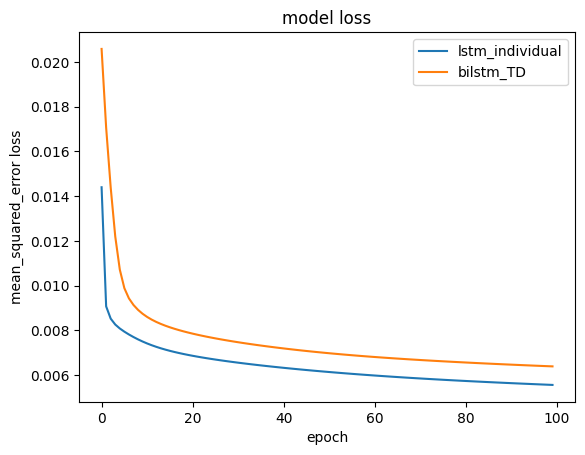

In [21]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
# plt.plot(history_batch.history['loss'])
plt.plot(history_TD_bilstm.history['loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error loss')
plt.xlabel('epoch')
plt.legend(['lstm_individual', 'bilstm_TD'], loc='upper right')
plt.show()

In [22]:
import numpy as np

y_pred = model.predict(X_test, batch_size=1)
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0, len(y_pred)):
#     print np.concatenate([y_pred[index],X_test[index]],axis=1)
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

214/214 [==============================] - 0s 488us/step


In [29]:
result_list = []
sales_dates = list(df_supervised_test.date)
act_sales = list(df_supervised_test.sales)

print(len(sales_dates))
print(len(pred_test_set_inverted))
for index in range(0, len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
df_result.head()

214
214


,pred_value,date
0,963343,2017-01-14
1,1451819,2017-01-15
2,557925,2017-01-16
3,721228,2017-01-17
4,832681,2017-01-18


In [30]:
from utils.score import ScoreRegression

scores = ScoreRegression()
scores.calculate(df_supervised_test["sales"], df_result["pred_value"])
print(scores)

ScoreRegression(r2=0.05524588956906573, mse=26397486978.25156, mae=129983.21413673223, rmsle=0.22048605821725814)


In [17]:
# #merge with actual sales dataframe
# df_sales_pred = pd.merge(df_supervised,df_result,on='date',how='left')
# #plot actual and predicted
# plot_data = [
#     go.Scatter(
#         x=df_sales_pred['date'],
#         y=df_sales_pred['sales'],
#         name='actual'
#     ),
#         go.Scatter(
#         x=df_sales_pred['date'],
#         y=df_sales_pred['pred_value'],
#         name='predicted'
#     )
    
# ]
# plot_layout = go.Layout(
#         title='Sales Prediction'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

In [31]:
submit_test = pd.read_csv("datasets/test.csv")

In [ ]:
df_submit = submit_test.copy()
df_submit['date'] = pd.to_datetime(df_submit['date'])
df_submit = df_submit.groupby('date').sales.sum().reset_index()